# 모델_1 긍정/부정 분류에 사용해볼 전처리
wordpiece적용위치\
mecab을 써서 토큰화한다.
불용어제거하지않고

RNN이 아닌 Transfomer모델을 써볼것이다.

In [2]:
#시각화용 임포트 모음
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
import pandas as pd

#1. Naver Sentiment Movie Corpus v1.0 다운로드
train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
train_text = open(train_file,'rb').read().decode(encoding='utf-8')

df_train = pd.DataFrame({
    'text':[ row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0 ],
    'sentiment': [ int(row.split('\t')[2]) for row in train_text.split('\n')[1:] if row.count('\t')>0]
})

# 데이터 크기 지정
df_train = df_train[::4]

#널값있는지 확인
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#널값제거
#빈 문자열을 NaN 값으로 대체
df_train[{'text','sentiment'}].replace('', np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df_train.dropna( inplace=True)

print(df_train)



빈 문자열이 없습니다.
                                                     text  sentiment
0                                     아 더빙.. 진짜 짜증나네요 목소리          0
4       사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...          1
8                                  액션이 없는데도 재미 있는 몇안되는 영화          1
12                    울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해          0
16      참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다.그...          1
...                                                   ...        ...
149980             아, 진짜 웃긴다...프랑스 영화 정말 싫어했었는데 이 영화는 열외~          1
149984     수술할정도로 아파본사람들만이 제대로 동감할수 있는영화..삶의 소중함.과 고마움...          1
149988             와~ 이런 것도 영화라고... 차라리 뮤직비디오를 만드는 게 나을 뻔          0
149992  공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 5...          0
149996                                      평점이 너무 낮아서...          1

[37500 rows x 2 columns]


C:\Users\uk246\AppData\Local\Temp\ipykernel_25276\1789648258.py:34: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_train[{'text','sentiment'}].replace('', np.nan, inplace=True)


In [3]:
# train 데이터 입력값(X)을 정제(Cleaning)
import re
from soynlp.normalizer import repeat_normalize

def clean_korean_text(text):
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ\s]', ' ', text)
    # 반복되는 자음, 모음 제거 (e.g., 'ㅋㅋㅋ' -> 'ㅋ')
    text = repeat_normalize(text, num_repeats=1)
    # 띄어쓰기 정규화 (연속된 공백 문자를 하나의 공백 문자로 변환)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_train['text']=df_train['text'].apply(lambda x:clean_korean_text(x))
df_train


,text,sentiment
0,아 더빙 진짜 짜증나네요 목소리,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
8,액션이 없는데도 재미 있는 몇안되는 영화,1
12,울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해,0
16,참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다 그...,1
...,...,...
149980,아 진짜 웃긴다 프랑스 영화 정말 싫어했었는데 이 영화는 열외,1
149984,수술할정도로 아파본사람들만이 제대로 동감할수 있는영화 삶의 소중함 과 고마움,1
149988,와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔,0
149992,공포나 재난영화가 아니라 아예 대놓고 비급 크리쳐개그물임ㅋㅋ 음악 완전 흥겹다ㅋ 점...,0


In [4]:
empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

#다시 널값 제거
# df_train['text'].apply(lambda x: x == "").drop(inplace=True)
df_train.drop(df_train[df_train['text'] == ""].index, inplace=True)

empty_string_exists = any(df_train['text'].apply(lambda x: x == ""))

if empty_string_exists:
    print("빈 문자열이 존재합니다.")
else:
    print("빈 문자열이 없습니다.")

빈 문자열이 존재합니다.
빈 문자열이 없습니다.


In [6]:
#정제된 텍스트를 벡터화하기전에 토큰화한다
from konlpy.tag import Mecab
# mecab=Mecab(dicpath=r'../../../../../../mecab/mecab-ko-dic/')
mecab=Mecab(dicpath=r'C:/mecab/mecab-ko-dic')

df_train['text']=df_train['text'].apply(lambda x: mecab.morphs(x))
df_train

,text,sentiment
0,"[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]",0
4,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, 스파이더맨, 에...",1
8,"[액션, 이, 없, 는데, 도, 재미, 있, 는, 몇, 안, 되, 는, 영화]",1
12,"[울, 면서, 손들, 고, 횡단, 보도, 건널, 때, 뛰쳐나올, 뻔, 이범수, 연기...",0
16,"[참, 사람, 들, 웃긴, 게, 바스코, 가, 이기면, 락스, 코, 라고, 까, 고...",1
...,...,...
149980,"[아, 진짜, 웃긴다, 프랑스, 영화, 정말, 싫, 어, 했었, 는데, 이, 영화,...",1
149984,"[수술, 할, 정도, 로, 아파, 본, 사람, 들, 만, 이, 제대로, 동감, 할,...",1
149988,"[와, 이런, 것, 도, 영화, 라고, 차라리, 뮤직, 비디오, 를, 만드, 는, ...",0
149992,"[공포, 나, 재난, 영화, 가, 아니, 라, 아예, 대놓고, 비급, 크리, 쳐, ...",0


In [7]:
#토큰화된걸 ' ' 공백한칸을 기준으로 다시 합쳐준다.
df_train['text']=df_train['text'].apply(lambda x: ' '.join(i for i in x) )
df_train
#==> 교착어의 단점을 보완해준것이다.

,text,sentiment
0,아 더 빙 진짜 짜증 나 네요 목소리,0
4,사이몬페그 의 익살 스런 연기 가 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 ...,1
8,액션 이 없 는데 도 재미 있 는 몇 안 되 는 영화,1
12,울 면서 손들 고 횡단 보도 건널 때 뛰쳐나올 뻔 이범수 연기 드럽 게 못해,0
16,참 사람 들 웃긴 게 바스코 가 이기면 락스 코 라고 까 고 바비 가 이기 면 아이...,1
...,...,...
149980,아 진짜 웃긴다 프랑스 영화 정말 싫 어 했었 는데 이 영화 는 열외,1
149984,수술 할 정도 로 아파 본 사람 들 만 이 제대로 동감 할 수 있 는 영화 삶 의 ...,1
149988,와 이런 것 도 영화 라고 차라리 뮤직 비디오 를 만드 는 게 나을 뻔,0
149992,공포 나 재난 영화 가 아니 라 아예 대놓고 비급 크리 쳐 개 그물 임 ㅋㅋ 음악 ...,0


리뷰의 최대 길이 : 227
리뷰의 평균 길이 : 40.998923747511164


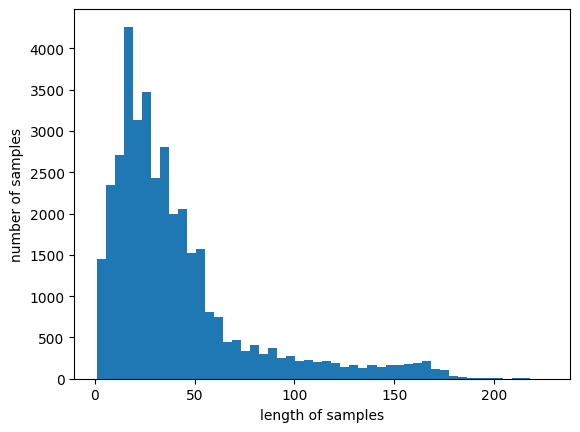

In [11]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in df_train['text']))
print('리뷰의 평균 길이 :',sum(map(len, df_train['text']))/len(df_train['text']))
plt.hist([len(review) for review in df_train['text']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

max_length = 64

word piece시작

In [201]:
# !pip install tokenizers
# !pip install transformers

In [12]:
# WordPiece 토큰화를 위한 사전 훈련된 모델 불러오기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [15]:
# a = tokenizer.batch_encode_plus(
#             '안녕하세요 나는 김찬란입니다.',
#             max_length=max_length,
#             padding="max_length",
#             truncation=True,
#             return_tensors="tf",
#             add_special_tokens=True,
#             return_attention_mask=True
#         )

# a.decode()

AttributeError: 

In [203]:

# def preprocess(texts, labels):
#     input_ids =[]
#     attention_masks = []
#     for text in texts:
#         input_tokens = tokenizer.batch_encode_plus(
#             [text],
#             max_length=max_length,
#             padding="max_length",
#             truncation=True,
#             return_tensors="tf",
#             add_special_tokens=True, 
#             return_attention_mask=True
#         )
#         input_ids.append(input_tokens['input_ids'][0])
#         attention_masks.append(input_tokens['attention_mask'][0])
#     # 차원 변경
#     input_ids = tf.stack(input_ids)
#     attention_masks = tf.stack(attention_masks)
#     labels = tf.convert_to_tensor(labels)
#     return {'input_ids':input_ids, 'attention_mask':attention_masks}, labels

def preprocess(texts, labels):
    input_ids = []
    attention_masks = []
    for text in texts:
        input_tokens = tokenizer.batch_encode_plus(
            [text],
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="tf",
            add_special_tokens=True,
            return_attention_mask=True
        )
        input_ids.append(input_tokens['input_ids'][0])
        attention_masks.append(input_tokens['attention_mask'][0])
    input_ids = tf.stack(input_ids)
    attention_masks = tf.stack(attention_masks)
    labels = tf.convert_to_tensor(labels)
    return {'input_ids': input_ids, 'attention_mask': attention_masks}, labels


In [204]:
from sklearn.model_selection import train_test_split

# 데이터 분할
train_texts, test_texts, train_labels, test_labels = train_test_split(df_train['text'], df_train['sentiment'], test_size=0.2)

print(test_texts[:5] ,test_labels[:5])

75228                           이렇게 지루 하 기 도 쉽 지 않 다 비추 입니다
79048                              화려 한 액션 은 아니 였 지만 그래도 성룡
18804     종영 후보 게 됨 왜 정규 방송 땐 관심없 었 을까 너무 유쾌 하 고 몇 회 않 남...
15196                                  북극대 탐험 이 제일 재미있 었 다고
135544                                           기모노 장난 하 냐
Name: text, dtype: object 75228     1
79048     1
18804     1
15196     1
135544    0
Name: sentiment, dtype: int64


C:\Users\uk246\AppData\Local\Temp\ipykernel_24156\717811488.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(test_texts[:5] ,test_labels[:5])


In [205]:
# 전처리 적용
train_data, train_labels = preprocess(train_texts, train_labels)
test_data, test_labels = preprocess(test_texts, test_labels)

In [206]:
#버트 분류모델 불러오기
from transformers import TFBertForSequenceClassification

# 모델 생성
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# 모델 학습
model.fit(train_data, train_labels, epochs=10, batch_size=64)

# 모델 평가
results = model.evaluate(test_data, test_labels)
print("Test loss, accuracy:", results)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
  3/465 [..............................] - ETA: 3:13:29 - loss: 0.9366 - accuracy: 0.5521

KeyboardInterrupt: 

In [ ]:
model.summary()

In [33]:
model.save('./wordpiece_test.h5')

In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#테스트문장 입력
test = ['회식끝나고 집가는중','개꿀잼이네','진짜 너무 별로다.','ㅋㅋㅋㅋㅋㅋㅋㅋ재밌따']

#정제
clean_test_texts=[]
for i in test:
    clean_test_texts.append(clean_korean_text(i))

max_length = 64
# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_test_texts]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

#벡터화
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=max_length) 

#예측
prediction = model.predict(x_test)  

for i in np.round(prediction):
    print(int(i))

1/1 [==============================] - 1s 561ms/step
0
1
0
1


# 서비스 테스트

In [35]:
#모델 불러오기
from tensorflow.keras.models import load_model
loaded_model= load_model('./wordpiece_test.h5')

# #저장된 vectorizer 불러오기
# import pickle
# with open('./lstm_tokenizer.pkl', 'rb') as f:
#     loaded_test_vectorizer = pickle.load(f)

In [37]:
# 카톡대화 불러와서 정제,(정규화코드)하는 함수
import re

def get_from_txt(txt):
    data= open(txt,"r", encoding='utf-8').read().split('\n')
    sentences=[]
    for line in data:
        pattern = r'\[(.*?)\]\s+\[(.*?)\]\s+(.+)'
        match = re.match(pattern, line)
        if match:
            name = match.group(1)  # 첫 번째 대괄호 안의 단어 추출
            time = match.group(2)  # 두 번째 대괄호 안의 단어 추출
            content = match.group(3)  # 대괄호 뒤의 내용 추출
            # print(name, time, content)
            temp=[name,time,content]
            sentences.append(temp)    
    return sentences

#함수확인
get_from_txt('sample.txt')

[['김찬란', '오후 10:01', '사진'],
 ['김찬란', '오후 9:38', 'https://youtube.com/watch?v=o1G7DWFFHso&feature=share'],
 ['김찬란', '오후 10:42', '사진'],
 ['김찬란', '오후 10:42', '사기치고다니는 한장규'],
 ['김하영', '오후 10:45', '이야'],
 ['김하영', '오후 10:46', '게임에서도 치네'],
 ['김찬란', '오후 10:46', '진짜 니말이 맞다 진짜 친구면 친구한테 민폐되기 싫어서 돈빌려달란 소리도 안한다'],
 ['김하영', '오전 12:25', '이모티콘'],
 ['김하영', '오전 12:35', '회식끝나고 집가는중'],
 ['김찬란', '오전 12:35', '음음 초밥집 회식은 어디서 하냐'],
 ['김하영', '오전 12:35', '우리 실장형네 직이 고기집해서 글로갔다'],
 ['김하영', '오전 12:36', '회식하면 맨날 돼지고기만 먹는다'],
 ['김찬란', '오전 12:36', 'ㅋㅋㅋㅋㅋㅋ케'],
 ['김하영', '오전 12:36', '이모티콘'],
 ['김찬란', '오전 12:36', '아 내수용 회식'],
 ['김찬란', '오전 12:36', '사진'],
 ['김하영', '오전 12:36', 'ㅋㅋㅋㅋ 그런거 아니고 애들이 여기가 맛있다고 여기서먹음'],
 ['김찬란', '오전 12:37', '고기 얘시하니까'],
 ['김찬란', '오전 12:37', '나도 고기가 먹고 싶군'],
 ['김하영', '오전 12:37', 'ㅋㅋㅋㅋ '],
 ['김찬란', '오전 12:37', '낼 사먹어야겠다'],
 ['김하영', '오전 12:37', '와라 엉아가 소고기 사줄께'],
 ['김찬란', '오전 12:37', '내가 사야지 씹새야 입벌려'],
 ['김찬란', '오전 12:37', '고기 들어간'],
 ['김찬란', '오전 12:38', '너는 내가 사주고 싶으니까 '],
 ['김찬란', '오전 12:38', '취직해서

In [38]:
#닉네임 입력단 
# target_name = str(input())
target_name = '김하영'
print(target_name)  #김하영 입력

김하영


In [68]:
# 저장된 모델 불러오기
# from tensorflow.keras.models import load_models
# model= load_models('4_6_DNN 토큰화수정.h5')


#입력된 이름의 '대화내역만' 담기
received_texts= []
for i in get_from_txt('sample.txt'): 
    if i[0] == target_name:
        received_texts.append( i[2] )
        
# 이모티콘, 사진, 샵검색 제거 
clean_received_texts2 = []
for i in received_texts:
    if '샵검색:' not in i: 
        if "이모티콘" not in i:
            if '사진' not in i:
                clean_received_texts2.append(str(i))

#=========== 이쯤에서 답장시간 계산기 구현   =======================
          
          
#텍스트 정제  
clean_received_texts2= [clean_korean_text(i) for i in clean_received_texts2]
clean_received_texts2

# 텍스트 데이터 토큰화
tokenized_test_texts = [tokenizer.encode(text, max_length=max_length, pad_to_max_length=True) for text in clean_received_texts2]
tokenized_test_texts

# 토큰화된 텍스트를 Numpy 배열로 변환
tokenized_test_texts = np.array(tokenized_test_texts)
tokenized_test_texts

# 벡터데이터 변환
x_test = pad_sequences(tokenized_test_texts,padding='post',maxlen=64) 

# 모델을 사용하여 예측 수행
predictions = loaded_model.predict(x_test)
#예측 결과 출력 (긍정: 1, 부정: 0)
print(predictions.squeeze().tolist()) #차원을 축소하고 리스트객체로 변환

cnt0=0;cnt1=0; cnt2=0
for i in predictions.squeeze().tolist():
    if i <= 0.45:
        cnt0+=1
    elif i >= 0.55:
        cnt1+=1
    else :
        cnt2+=1
        
#부정과 긍정문의 갯수
print('부정문과 긍정문의 갯수:',cnt0,cnt1)
print('중립문장의 갯수:',cnt2)

#긍정과 부정의 비율( 긍정문의 수 / 부정문의 수)
print('긍정과 부정의 비율: ',cnt1/cnt0)
#숫자가 1이상이고 높을수록 긍정적이다.

6/6 [==============================] - 0s 7ms/step
[0.42015233635902405, 0.15778325498104095, 0.4034382998943329, 0.15830516815185547, 0.2756638824939728, 0.23274767398834229, 0.5671480298042297, 0.25340867042541504, 0.4362293481826782, 0.4002711772918701, 0.6111466884613037, 0.06004936248064041, 0.1837492287158966, 0.1312265843153, 0.2406095564365387, 0.08809877932071686, 0.3380661606788635, 0.17884549498558044, 0.544122040271759, 0.5671480298042297, 0.3253222107887268, 0.34540876746177673, 0.34540876746177673, 0.4286506474018097, 0.5671480298042297, 0.28317803144454956, 0.5671480298042297, 0.11938949674367905, 0.4006653428077698, 0.19541098177433014, 0.12212876230478287, 0.31381163001060486, 0.3801400661468506, 0.3815697431564331, 0.5671480298042297, 0.4159267246723175, 0.4814023971557617, 0.3980425298213959, 0.24305537343025208, 0.3207646906375885, 0.12008189409971237, 0.32288381457328796, 0.5671480298042297, 0.5671480298042297, 0.42395874857902527, 0.4516054093837738, 0.19916307926

In [ ]:
clean_received_texts2